Library importing

In [1]:
import os
import pandas as pd
import regex as re
import numpy as np
import spacy
from rapidfuzz import process
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

Dataseti ayarlama ve yükleme

In [2]:
path = ".\datasets"

In [3]:
def load_news_articles(base_path):
    data = []
    categories = os.listdir(base_path)
    
    for category in categories:
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)
                with open(file_path, 'r', encoding = 'latin1') as file:
                    content = file.read()
                    data.append((content, category))
    
    return pd.DataFrame(data, columns = ['text', 'category'])

news_df = load_news_articles(path)

In [4]:
news_df

,text,category
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business
...,...,...
2220,BT program to beat dialler scams\n\nBT is intr...,tech
2221,Spam e-mails tempt net shoppers\n\nComputer us...,tech
2222,Be careful how you code\n\nA new European dire...,tech
2223,US cyber security chief resigns\n\nThe man mak...,tech


Named-Entitiy

In [5]:
def preserve_entities(text):
    doc = nlp(text)
    preserved = text
    for ent in doc.ents:
        tag = f"<{ent.label_}:{ent.text.replace(' ', '_')}>" # Replace spaces with underscores in the entity text
        preserved = preserved.replace(ent.text, tag) # Preserve the entity text
    return preserved

In [6]:
news_df['text_preserved'] = news_df['text'].apply(preserve_entities)

Regex

In [7]:
def clean_text(text):
    # HTML taglerini kaldır
    text = re.sub(r'<.*?>', ' ', text)

    # URL'leri kaldır
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)

    # E-mail adreslerini kaldır
    text = re.sub(r'\S+@\S+', ' ', text)

    # Sayıları kaldır
    text = re.sub(r'\d+', ' ', text)

    # Sadece harfleri ve boşlukları bırak
    text = re.sub(r'[^a-zA-Z\s<>_:]', ' ', text)  # <ENTITY_TAG> formatına zarar vermez.

    # Küçük harfe çevir
    text = text.lower()

    # Birden fazla boşluğu tek boşluk yap
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [8]:
news_df['text_cleaned'] = news_df['text_preserved'].apply(clean_text)

In [9]:
print(news_df[['text', 'text_preserved', 'text_cleaned']].sample(1).to_string())

In [10]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Noktalama işaretlerini kaldır
    return text


In [11]:
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])


In [12]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])


In [13]:
news_df['clean_text'] = news_df['text'].apply(preserve_entities)
news_df['clean_text'] = news_df['clean_text'].apply(normalize_text)
news_df['clean_text'] = news_df['clean_text'].apply(lemmatize_text)
# news_df['clean_text'] = news_df['clean_text'].apply(stem_text)  # İsteğe bağlı olarak açılabilir


In [14]:
def correct_typos(text, vocab, threshold=90):
    corrected_words = []
    for word in text.split():
        if word in vocab or word.startswith("<") or word.endswith(">"):
            corrected_words.append(word)
        else:
            match, score, _ = process.extractOne(word, vocab)
            if score >= threshold:
                corrected_words.append(match)
            else:
                corrected_words.append(word)
    return ' '.join(corrected_words)


In [15]:
vectorizer_vocab = CountVectorizer(min_df=5)
vectorizer_vocab.fit(news_df['clean_text'])
vocab = set(vectorizer_vocab.get_feature_names_out())


In [16]:
news_df['clean_text'] = news_df['clean_text'].apply(lambda text: correct_typos(text, vocab))

In [17]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_df=0.80,
    min_df=3,
    max_features=8000,
    sublinear_tf=True,
    stop_words='english'
)
X_tfidf = vectorizer.fit_transform(news_df['clean_text'])


y = news_df['category']

In [18]:
print("TF-IDF shape:", X_tfidf.shape)
print("Sample feature names:", vectorizer.get_feature_names_out()[:10])


TF-IDF shape: (2225, 8000)
Sample feature names: ['10' '10 theme' '100' '100 theme' '10000' '100000' '10bn' '11' '11 theme'
 '11bn']


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.2, random_state = 42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
                precision    recall  f1-score   support

     business       0.94      0.97      0.95       115
entertainment       0.99      0.92      0.95        72
     politics       0.91      0.96      0.94        76
        sport       0.99      0.99      0.99       102
         tech       0.97      0.95      0.96        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



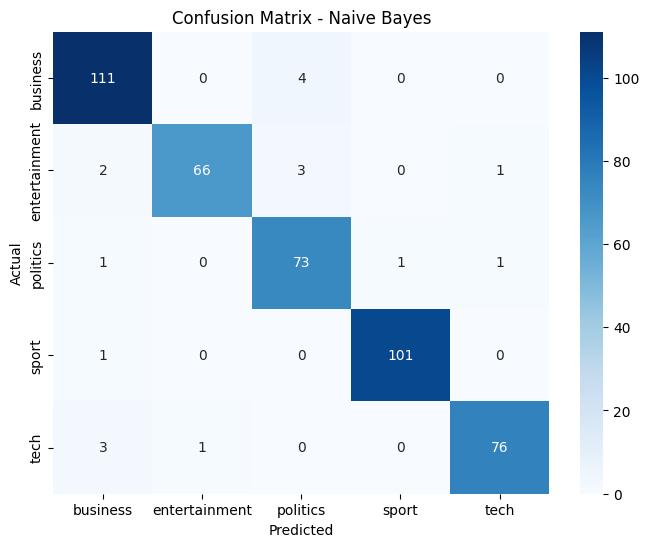

In [20]:
labels = sorted(news_df['category'].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

In [21]:
def show_top_features_nb(classifier, vectorizer, class_labels, n=10):
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top_indices = np.argsort(classifier.feature_log_prob_[i])[-n:]
        top_features = [feature_names[j] for j in top_indices]
        print(f"\nTop features for '{class_label}':")
        print(", ".join(top_features))
show_top_features_nb(nb_model, vectorizer, nb_model.classes_)



Top features for 'business':
price, sale, economy, share, rise, growth, money, firm, market, company

Top features for 'entertainment':
work, album, good, include, actor, person person, music, award, star, film

Top features for 'politics':
secretary, mr person, leader, people, plan, party, minister, government, election, mr

Top features for 'sport':
time, coach, theme, team, person person, match, player, play, game, win

Top features for 'tech':
firm, net, service, mobile, software, use, computer, user, technology, people


Hyperparameter Tuning

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [23]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [24]:
models = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        "clf__C": [0.01, 0.1, 1, 10],           # Added smaller C values
        "clf__penalty": ['l1', 'l2', 'elasticnet'],  # Different penalties
        "clf__solver": ['liblinear', 'saga']      # Compatible solvers
    }),
    "DecisionTree": (DecisionTreeClassifier(random_state=42), {
        "clf__max_depth": [5, 10, 15, 20],       # Added shallower trees
        "clf__min_samples_split": [5, 10, 20],   # Increased minimum splits
        "clf__min_samples_leaf": [2, 5, 10],     # Added leaf constraints
        "clf__max_features": ['sqrt', 'log2', None]  # Feature sampling
    }),
    "SVM": (LinearSVC(max_iter=10000, random_state=42), {
        "clf__C": [0.01, 0.1, 1, 10],           # Added smaller C values
        "clf__penalty": ['l1', 'l2'],            # L1 for sparsity
        "clf__dual": [False]                     # For l1 penalty
    }),
    "MLP": (MLPClassifier(max_iter=500, random_state=42), {
        "clf__hidden_layer_sizes": [(50,), (100,), (100, 50)],  # Smaller networks
        "clf__alpha": [0.001, 0.01, 0.1],       # Stronger regularization
        "clf__early_stopping": [True],          # Early stopping
        "clf__validation_fraction": [0.1]       # Validation set for early stopping
    })
}

In [25]:
log_reg = LogisticRegression(C=1, penalty='l2', max_iter=1000)
svm = LinearSVC(C=0.1, max_iter=10000)
rf = RandomForestClassifier(n_estimators=100, max_depth=15, 
                            min_samples_split=10, random_state=42)

voting_ensemble = VotingClassifier(
    estimators=[('lr', log_reg), ('svm', svm), ('rf', rf)], 
    voting='soft'
)

models["RandomForest"] = (RandomForestClassifier(random_state=42), {
    "clf__n_estimators": [50, 100],
    "clf__max_depth": [10, 15, 20],
    "clf__min_samples_split": [5, 10],
    "clf__min_samples_leaf": [2, 5]
})

models["VotingEnsemble"] = (voting_ensemble, {})


In [26]:
from sklearn.model_selection import cross_val_score

results = {}

for name, (model, param_grid) in models.items():
    print(f"\nTraining and tuning {name}...")
    pipeline = Pipeline([('clf', model)])
    
    grid = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=cv_strategy, 
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    cv_scores = cross_val_score(best_model, X_train, y_train, 
                                cv=cv_strategy, scoring='f1_macro')

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    print(f"{name}")
    print(f"  - CV Score: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")
    print(f"  - Training Accuracy: {train_acc:.4f}")
    print(f"  - Testing Accuracy : {test_acc:.4f}")
    print(f"  - Gap: {train_acc - test_acc:.4f}")
    print(f"  - Best Params: {grid.best_params_}")

    results[name] = {
        'model': best_model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'cv_score': cv_mean,
        'cv_std': cv_std,
        'acc_gap': train_acc - test_acc,
        'params': grid.best_params_
    }



Training and tuning LogisticRegression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nl

LogisticRegression
  - CV Score: 0.9781 (+/- 0.0153)
  - Training Accuracy: 1.0000
  - Testing Accuracy : 0.9708
  - Gap: 0.0292
  - Best Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'saga'}

Training and tuning DecisionTree...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
DecisionTree
  - CV Score: 0.7970 (+/- 0.0212)
  - Training Accuracy: 0.9399
  - Testing Accuracy : 0.8202
  - Gap: 0.1197
  - Best Params: {'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 20}

Training and tuning SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
SVM
  - CV Score: 0.9805 (+/- 0.0120)
  - Training Accuracy: 1.0000
  - Testing Accuracy : 0.9753
  - Gap: 0.0247
  - Best Params: {'clf__C': 1, 'clf__dual': False, 'clf__penalty': 'l2'}

Training and tuning MLP...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 754, in fit
    return self._fit(X, y, incremental=False)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 476, in _fit
    self._fit_stochastic(
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 660, in _fit_stochastic
    self._update_no_improvement_count(early_stopping, X_val, y_val)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 708, in _update_no_improvement_count
    val_score = self._score(X_val, y_val)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 1194, in _score
    return super()._score_with_function(X, y, score_function=accuracy_score)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 769, in _score_with_function
    if np.isnan(y_pred).any() or np.isinf(y_pred).any():
TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


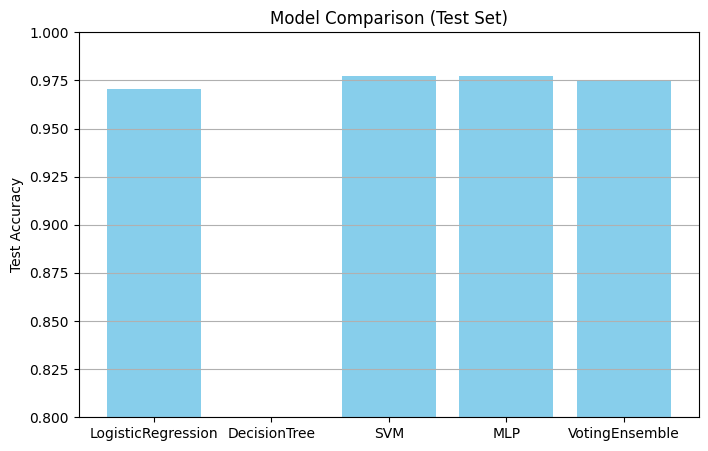

In [ ]:
names = list(results.keys())
accuracies = [results[name]['test_acc'] for name in names] 

plt.figure(figsize=(8, 5))
plt.bar(names, accuracies, color='skyblue')
plt.ylabel("Test Accuracy")
plt.title("Model Comparison (Test Set)")
plt.ylim(0.8, 1.0)
plt.grid(True, axis='y')
plt.show()


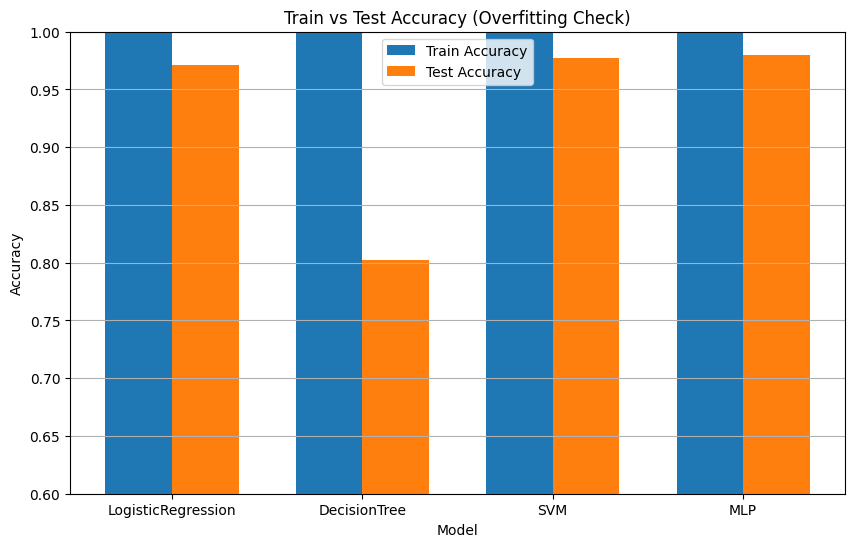

In [ ]:
model_names = list(results.keys())
train_scores = [results[m]['train_acc'] for m in model_names]
test_scores = [results[m]['test_acc'] for m in model_names]
gaps = [results[m]['acc_gap'] for m in model_names]

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(model_names))

plt.bar(x, train_scores, width=bar_width, label='Train Accuracy')
plt.bar([i + bar_width for i in x], test_scores, width=bar_width, label='Test Accuracy')
plt.xticks([i + bar_width / 2 for i in x], model_names)
plt.ylim(0.6, 1.0)
plt.title('Train vs Test Accuracy (Overfitting Check)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, axis='y')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("\n" + "="*30)
print("Classification Reports")
print("="*30)

for name, data in results.items():
    model = data['model']
    y_pred = model.predict(X_test)

    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))



Classification Reports

Model: LogisticRegression
               precision    recall  f1-score   support

     business       0.94      0.97      0.96       115
entertainment       0.99      0.97      0.98        72
     politics       0.95      0.96      0.95        76
        sport       1.00      0.99      1.00       102
         tech       0.99      0.95      0.97        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445


Model: DecisionTree
               precision    recall  f1-score   support

     business       0.78      0.76      0.77       115
entertainment       0.83      0.68      0.75        72
     politics       0.74      0.82      0.78        76
        sport       0.82      0.84      0.83       102
         tech       0.78      0.84      0.81        80

     accuracy                           0.79       445
    macro avg       0.79      0.79      0.7

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_macro'
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1)
    plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curves - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

best_model_name = max(results.keys(), key=lambda k: results[k]['test_acc'])
best_model = results[best_model_name]['model']
plot_learning_curves(best_model, X_train, y_train, best_model_name)

print(f"\nBest model: {best_model_name} with test accuracy: {results[best_model_name]['test_acc']:.4f}")


In [ ]:
import joblib

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(results["VotingEnsemble"]["model"], "news_classifier.pkl")


['news_classifier.pkl']